# EQUINE Example on VPN/NonVPN Network Application Traffic Dataset (VNAT) 

This example showcases how to use an EQUINE class to analyze [an encrypted network traffic dataset](https://www.ll.mit.edu/r-d/datasets/vpnnonvpn-network-application-traffic-dataset-vnat). The general question of interest from this dataset is whether it is possible to discern the application that generated network traffic, even if that traffic is routed through a Virtual Private Network (VPN).
To try this example out, you will need to download the connections dataframe from that location and place it in the same directory as this notebook.  For more information, [check out this paper](https://doi.ieeecomputersociety.org/10.1109/TAI.2023.3244168) in the IEEE Journal, Transactions of Artificial Intelligence.

In this example, we'll demonstrate how to add labels and features to the dataframe and then train an `EquineProtonet` model, holding out two of the five classes, in order to evaluate its performance at assigning relatively high out-of-distribution scores for the two held-out classes.

In [1]:
# This notebook requires additional pythom modules and a dataset to run. 
# You can uncomment the following lines to install them in your environment.
# !curl -o VNAT_Dataframe_release_1.h5 https://archive.ll.mit.edu/datasets/vnat/VNAT_Dataframe_release_1.h5 
# !conda install pytables
# !pip install scikit-learn pandas

In [2]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

import equine as eq

## Dataset Preparation
We'll use pandas to read the HDF5 file. It should produce a dataframe with the keys "connection", "timestamps", "sizes", "directions" and "file_names". 

In [3]:
data_path = "VNAT_Dataframe_release_1.h5"
vnat_df = pd.read_hdf(data_path)
print("Shape is ", vnat_df.shape)
vnat_df.head()

Shape is  (33711, 5)


,connection,timestamps,sizes,directions,file_names
0,"(10.123.1.2, 1195, 10.123.1.1, 1195, 17)","[1563289706.330096, 1563289706.330207, 1563289...","[120, 88, 120, 88, 120, 88, 120, 120, 152, 120...","[1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, ...",vpn_youtube_capture2.pcap
0,"(10.113.1.2, 22924, 10.115.1.2, 53, 17)","[1561391908.523659, 1561391908.524042]","[63, 79]","[1, 0]",nonvpn_sftp_newcapture1.pcap
1,"(10.113.1.2, 53065, 10.115.1.2, 53, 17)","[1561391908.523706, 1561391908.524059]","[63, 63]","[1, 0]",nonvpn_sftp_newcapture1.pcap
2,"(10.113.1.150, 39816, 10.115.1.123, 22, 6)","[1561391908.524836, 1561391908.525027, 1561391...","[60, 60, 52, 73, 52, 73, 52, 1378, 222, 52, 13...","[1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, ...",nonvpn_sftp_newcapture1.pcap
3,"(10.115.1.2, 6589, 10.113.1.2, 53, 17)","[1561391908.594887, 1561391908.595301]","[51, 102]","[1, 0]",nonvpn_sftp_newcapture1.pcap


Following the table from the [download site](https://www.ll.mit.edu/r-d/datasets/vpnnonvpn-network-application-traffic-dataset-vnat), we'll use the filenames to generate some overarching labels. Here, "FT" means file-transfer, and "C2" means "command-and-control" (i.e., these applications feature two-way traffic where commands are issued). It is also possible to create VPN and non-VPN categories, etc.

In [4]:
app_to_label = { "vimeo":"streaming", "netflix":"streaming", "youtube":"streaming", 
    "voip":"voip",
    "skype-chat":"chat",
    "ssh":"C2", "rdp":"C2",
    "sftp":"FT", "rsync":"FT", "scp":"FT"}

apps = np.array(list(app_to_label.keys()))
def label_match(filename):
    words = filename.split('_')
    app = words[1] # Application name is second in filename
    matches = apps[apps == app]
    label = app_to_label[matches[0]] 
    return label

vnat_df["labels"] = vnat_df.file_names.apply(lambda x: label_match(x))

### Feature Generation
Next, we'll generate some simple "transport layer statistics" to use as classification features. Essentially, these are statistical features calculated over the entirety of each connection, including things like the average "interarrival times" between packets, the total amount of bytes transferred, etc. Note that the below code filters any connections with fewer than 10 packets in either direction or shorter than 30 seconds. 

In [5]:
def calculate_features(row):
    forward_backward_mask = np.array(row.directions, dtype=bool)
    ts = np.array(row.timestamps)
    duration = ts[-1]-ts[0]

    # split out "forward" and "backward" timestamps
    ts_forward = ts[forward_backward_mask] 
    ts_backward = ts[~forward_backward_mask]

    # Bail out if this connection is too short or has very little data
    if duration < 30.0 or len(ts_forward) < 10 or len(ts_backward) < 10:
        return tuple(16*[pd.NA])

    # Statistics for forward interarrival times
    forward_interarrivals = ts_forward[1:]-ts_forward[:-1]
    fiat_mean = np.mean(forward_interarrivals)
    fiat_std = np.std(forward_interarrivals)
    fiat_max = np.max(forward_interarrivals)
    fiat_min = np.min(forward_interarrivals)

    # Statistics for backward interarrival times
    backward_interarrivals = ts_backward[1:]-ts_backward[:-1]
    biat_mean = np.mean(backward_interarrivals)
    biat_std = np.std(backward_interarrivals)
    biat_max = np.max(backward_interarrivals)
    biat_min = np.min(backward_interarrivals)

    # Size statisticstics 
    sizes = np.array(row.sizes)
    total_forward = len(ts_forward)
    total_backward = len(ts_backward)
    bytes_forward = sum(sizes[forward_backward_mask])
    bytes_backward = sum(sizes[~forward_backward_mask])
    bytes_per_sec = (bytes_forward + bytes_backward) / duration
    num_unique_forward_sizes = len(np.unique(sizes[forward_backward_mask]))
    num_unique_backward_sizes = len(np.unique(sizes[~forward_backward_mask]))

    return  (duration, fiat_mean, fiat_std, fiat_max, fiat_min, 
            biat_mean, biat_std, biat_max, biat_min, 
            total_forward, total_backward, 
            bytes_forward, bytes_backward, bytes_per_sec, 
            num_unique_forward_sizes, num_unique_backward_sizes)

In [6]:
# Add the features to the dataframe
vnat_df[["duration", "fiat_mean", "fiat_std", "fiat_max", "fiat_min",
 "biat_mean", "biat_std", "biat_max", "biat_min", "total_forward", 
 "total_backward", "bytes_foward", "bytes_backward", "bytes_per_sec",
  "num_unique_forward_sizes", "num_unique_backward_sizes"]] = vnat_df.apply(
    calculate_features, axis=1, result_type='expand')

### Grouped Data Characteristics
Note here that we have grouped only by application type. Since there are few remaining single-connection examples of file-transfer and VOIP, we'll hold those out for out-of-distribution testing.

In [7]:
vnat_df.drop(["connection", "timestamps", "sizes", "directions", "file_names"],axis=1, inplace=True)
vnat_df.dropna(inplace=True)
vnat_df.groupby("labels").describe()

duration                           fiat_mean                        \
             count unique           top freq     count unique       top freq   
labels                                                                         
C2           379.0  379.0  26542.717629  1.0     379.0  379.0  8.918924  1.0   
FT            30.0   30.0    473.359046  1.0      30.0   30.0  0.000514  1.0   
chat         152.0  151.0  17990.640175  2.0     152.0  151.0  2.911578  2.0   
streaming    671.0  671.0    800.568697  1.0     671.0  671.0  0.039530  1.0   
voip          12.0   12.0   1819.484871  1.0      12.0   12.0  0.019927  1.0   

          fiat_std         ... bytes_per_sec      num_unique_forward_sizes  \
             count unique  ...           top freq                    count   
labels                     ...                                               
C2           379.0  379.0  ...  2.330914e+01  1.0                    379.0   
FT            30.0   30.0  ...  3.859252e+06  1.0                     30.0   
chat         152.0  151.0  ...  1.853004e+02  2.0                    152.0   
streaming    671.0  671.0  ...  7.286141e+04  1.0                    671.0   
voip          12.0   12.0  ...  8.418154e+03  1.0                     12.0   

                              num_unique_backward_sizes                      
          unique   top   freq                     count unique   top   freq  
labels                                                                       
C2          20.0  14.0  338.0                     379.0   27.0  13.0   57.0  
FT          17.0  15.0    4.0                      30.0   19.0  13.0    5.0  
chat        49.0  24.0   25.0                     152.0   54.0  26.0   22.0  
streaming   49.0   9.0  107.0                     671.0  107.0   8.0  109.0  
voip         6.0   1.0    5.0                      12.0    6.0   1.0    5.0  

[5 rows x 64 columns]

In [8]:
# Drop a couple of the classes with a small number of total connections
vnat_df_no_voip = vnat_df[vnat_df.labels != "voip"]
vnat_df_drop2 = vnat_df_no_voip[vnat_df_no_voip.labels != "FT"]

# Encode the labels as integers
encoder = LabelEncoder()
encoded_labels = torch.IntTensor(encoder.fit_transform(vnat_df_drop2["labels"]))

# Create the tensor input data, dropping the labels
data = torch.FloatTensor(np.array(vnat_df_drop2.drop(["labels"], axis=1).values, dtype=np.float32))
dataset = torch.utils.data.TensorDataset(data,encoded_labels)
trainset, testset = torch.utils.data.random_split(dataset, [0.8, 0.2], 
                    generator=torch.Generator().manual_seed(52))

# Pull out the train/test tensors for the protonet
train_x = trainset.dataset.tensors[0][trainset.indices]
train_y = trainset.dataset.tensors[1][trainset.indices]
test_x = trainset.dataset.tensors[0][testset.indices]
test_y = trainset.dataset.tensors[1][testset.indices]

# Store some helpful variables for the emedding model and data normalization
input_dim = data.shape[1]
num_classes = len(np.unique(vnat_df_drop2.labels))

train_means = train_x.mean(0, keepdim=True)
train_deviations = train_x.std(0, keepdim=True)

## Create an Embedding Model and train a Neural Network

We next create a simple embedding model that we'll use to train from scratch using the `train_episodes` method in `EquineProtonet`. Given that the predictions are on the entire connnections (and some of them are pretty long), this is not too challenging a prediction problem, even though some of the connections are tunnneled through a VPN. This is because the size and timing characteristics of the connections are not always obscured by VPNs. 

In [9]:
num_deep_features = 32
class EmbeddingModel(torch.nn.Module):
    def __init__(self):
        super(EmbeddingModel, self).__init__()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(input_dim, num_deep_features),
            torch.nn.ReLU(),
            torch.nn.Linear(num_deep_features, num_deep_features),
            torch.nn.ReLU(),
            torch.nn.Linear(num_deep_features, num_deep_features),
            torch.nn.ReLU(),
            torch.nn.Linear(num_deep_features, num_deep_features),
        )

    def forward(self, x):
        x = (x - train_means ) / train_deviations
        logits = self.linear_relu_stack(x)
        return logits

### Train a model
Here we create the Neural Network from scratch using the above feature embedding model and perform episodic training. Other examples showcase how one can pretrain and freeze layers in the feature embedding model, but for this example, we simply train from scratch, which should only take a few seconds on a CPU.

In [10]:
model = eq.EquineProtonet(EmbeddingModel(),  num_deep_features)
model.train_model(torch.utils.data.TensorDataset(train_x,train_y),
                    way=num_classes,   # Number of classes to train each episode
                    support_size=20,   # Number of support examples per class each episode
                    num_episodes=1000, # Number of episodes (like epochs)
                    episode_size=100)  # Number of examples per episode (like batch size)

100%|██████████| 1000/1000 [00:02<00:00, 469.65it/s]


{'numTrainExamples': [{'label': 0, 'numExamples': 233},
  {'label': 1, 'numExamples': 101},
  {'label': 2, 'numExamples': 435}],
 'dateTrained': '06/14/2023, 13:33:45',
 'modelType': 'EquineProtonet'}

In [11]:
test_results = model.predict(test_x)
acc = sum((torch.argmax(test_results.classes,1)==test_y).to(int))/len(test_results.classes)
print(acc)

tensor(0.9792)


You should see a relatively high accuracy (>95%). Next, we consider the problem of handling network traffic generated by applications that were not seen by the model.

### Out of distribution study
Here we demonstrate that the remaining two application categories, VOIP and File Transfer (FT), which were not included in the model training, produce relatively high out-of-distribution, represented by the `ood_scores` in `EquineOutput`. In the below cell, we consider the held-out test data as in-distribution for reference, whereas the VOIP and FT connections are the `ood_data`. To generate a ROC curve, we concatenate the test and OOD data together and use the `ood_scores` as a signifier as to whether they were in- or out-of-distribution. The histogram should reveal thaat the majority of the OOD data is in the highest scoring bin (closest to 1.0). 

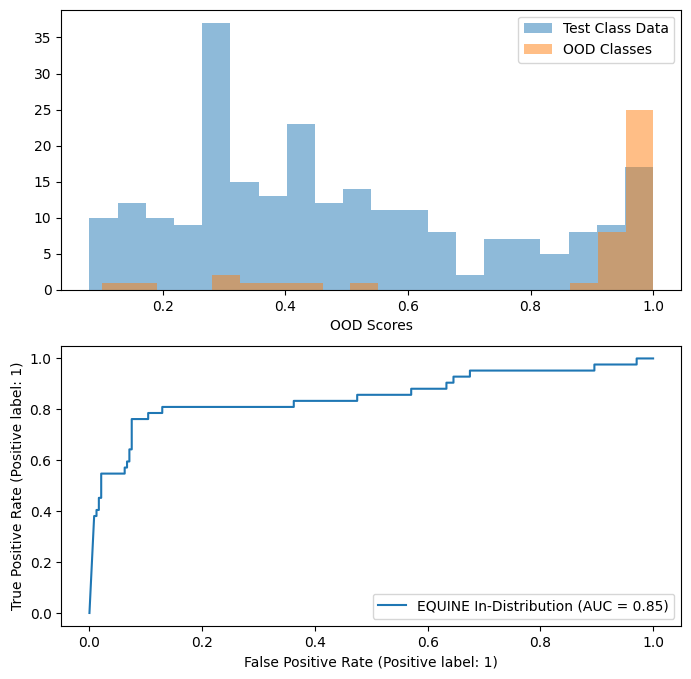

In [13]:
ood_df = vnat_df[(vnat_df.labels == "voip") | (vnat_df.labels == "FT")]
ood_data = torch.FloatTensor(np.array(ood_df.drop(["labels"], axis=1).values, dtype=np.float32))
ood_results = model.predict(ood_data)

fig, ax = plt.subplots(2,1, figsize=(8,8))

ax[0].hist(test_results.ood_scores, bins=20, alpha=0.5, label="Test Class Data")
ax[0].hist(ood_results.ood_scores, bins=20, alpha=0.5, label="OOD Classes")
ax[0].set_xlabel("OOD Scores")
ax[0].legend()

in_out = torch.concat((torch.zeros(len(test_results.ood_scores)), torch.ones(len(ood_results.ood_scores))))
all_oods = torch.concat((test_results.ood_scores,ood_results.ood_scores))

RocCurveDisplay.from_predictions(in_out, all_oods, name="EQUINE In-Distribution", ax=ax[1])
plt.show()
